In [1]:
import numpy as np
import pickle as pickle
from scipy import signal
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt

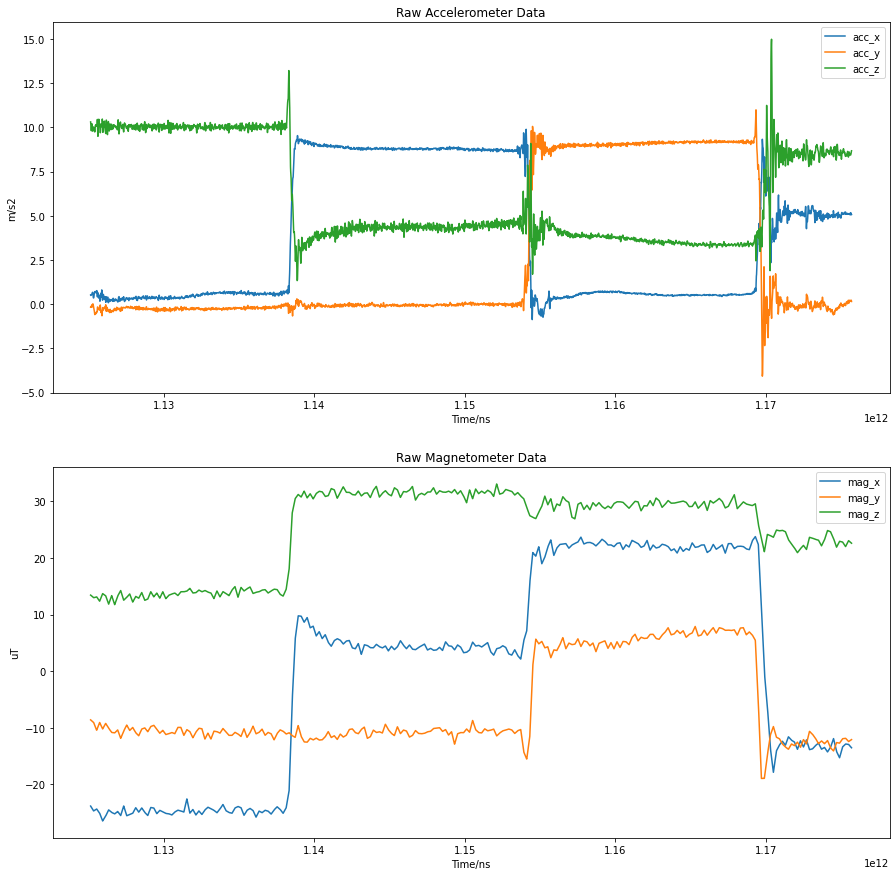

In [2]:
with open("./aggregated.pkl", "rb") as fid:
    data = pickle.load(fid)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,15))

# Retrieve ACC data.                                                                                                                                                    
ts_ACC = data['ACC'][:,0]  # Timestamps for ACC data.
acc_x = data['ACC'][:,1]
acc_y = data['ACC'][:,2]
acc_z = data['ACC'][:,3]

# Retrieve MAG data.
ts_MAG = data['MAG'][:,0]  # Timestamps for MAG data.
mag_x = data['MAG'][:,1]
mag_y = data['MAG'][:,2]
mag_z = data['MAG'][:,3]

# Orientation results.
ts_ORI = data['ORI'][:,0]  # Timestamps for ORIENTATION data.
pitch_ref = data['ORI'][:,1]
yaw_ref = data['ORI'][:,2]
roll_ref = data['ORI'][:,3]

# Plot ACC data.
ax1.plot(ts_ACC, acc_x)
ax1.plot(ts_ACC, acc_y)
ax1.plot(ts_ACC, acc_z)
ax1.set(xlabel='Time/ns', ylabel='m/s2', title='Raw Accelerometer Data')
ax1.legend(['acc_x', 'acc_y', 'acc_z'])

# Plot MAG data.
ax2.plot(ts_MAG, mag_x)
ax2.plot(ts_MAG, mag_y)
ax2.plot(ts_MAG, mag_z)
ax2.set(xlabel='Time/ns', ylabel='uT', title='Raw Magnetometer Data')
ax2.legend(['mag_x', 'mag_y', 'mag_z'])

# Part a.

In [3]:

class Preprocessing:

    def __init__(self, acc_x, acc_y, acc_z, mag_x, mag_y, mag_z):
        self.acc_x = acc_x
        self.acc_y = acc_y
        self.acc_z = acc_z
        self.mag_x = mag_x
        self.mag_y = mag_y
        self.mag_z = mag_z


    @staticmethod
    def normalize(a, b, c):
        return 1 / (np.sqrt(((a**2) + (b**2) + (c**2))))
    

    def getRotationMatrix(acc_x, acc_y, acc_z, mag_x, mag_y, mag_z):
        a = np.array(([acc_x], [acc_y], [acc_z]))
        m = np.array(([mag_x], [mag_y], [mag_z]))
        a_cross_m = np.cross(a, m, axis=0)
        a_cross_m_a = np.cross(a_cross_m, a, axis=0)

        col0 = Preprocessing.normalize(a_cross_m_a[0], a_cross_m_a[1], a_cross_m_a[2]) * a_cross_m_a
        col1 = Preprocessing.normalize(a_cross_m[0], a_cross_m[1], a_cross_m[2]) * a_cross_m
        col2 = Preprocessing.normalize(a[0], a[1], a[2]) * a

        R = np.hstack((
            col0,
            col1,
            col2
        ))

        return R

    
    def getOrientation(R):
        pitch = - np.arcsin(R[0][2])
        yaw = np.arctan2(R[1][2],R[2][2])
        roll = np.arctan2(R[0][1],R[0][0])

        return (pitch, yaw, roll)


all_pitch = []
all_yaw = []
all_roll = []

for i in range(len(acc_x)):
    R = Preprocessing.getRotationMatrix(acc_x[i], acc_y[i], acc_z[i], mag_x[i], mag_y[i], mag_z[i])
    (pitch, yaw, roll) = Preprocessing.getOrientation(R)
    all_pitch.append(pitch)
    all_yaw.append(yaw)
    all_roll.append(roll)

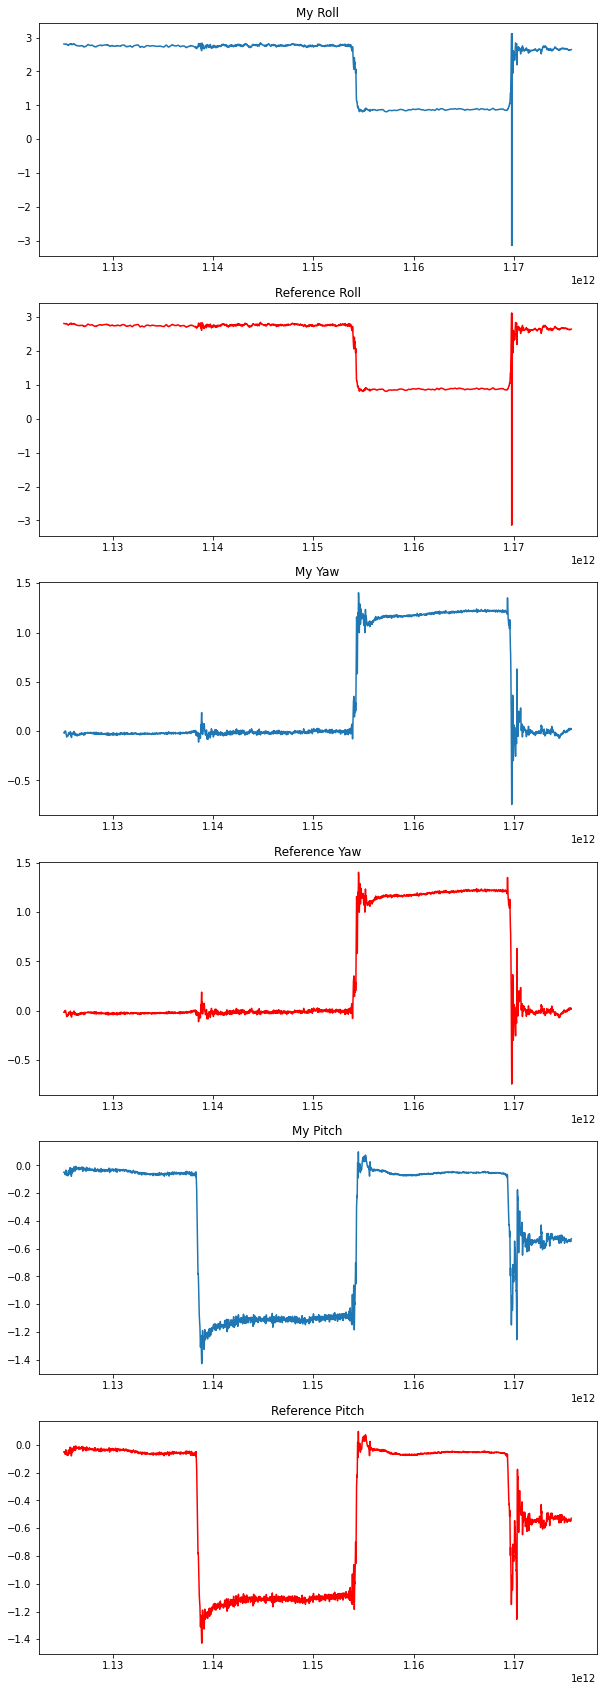

In [4]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(10,30))

ax1.plot(ts_ORI, all_roll)
ax1.title.set_text('My Roll')
ax2.plot(ts_ORI, roll_ref, color='r')
ax2.title.set_text('Reference Roll')

ax3.plot(ts_ORI, all_yaw)
ax3.title.set_text('My Yaw')
ax4.plot(ts_ORI, yaw_ref, color='r')
ax4.title.set_text('Reference Yaw')


ax5.plot(ts_ORI, all_pitch)
ax5.title.set_text('My Pitch')
ax6.plot(ts_ORI, pitch_ref, color='r')
ax6.title.set_text('Reference Pitch')



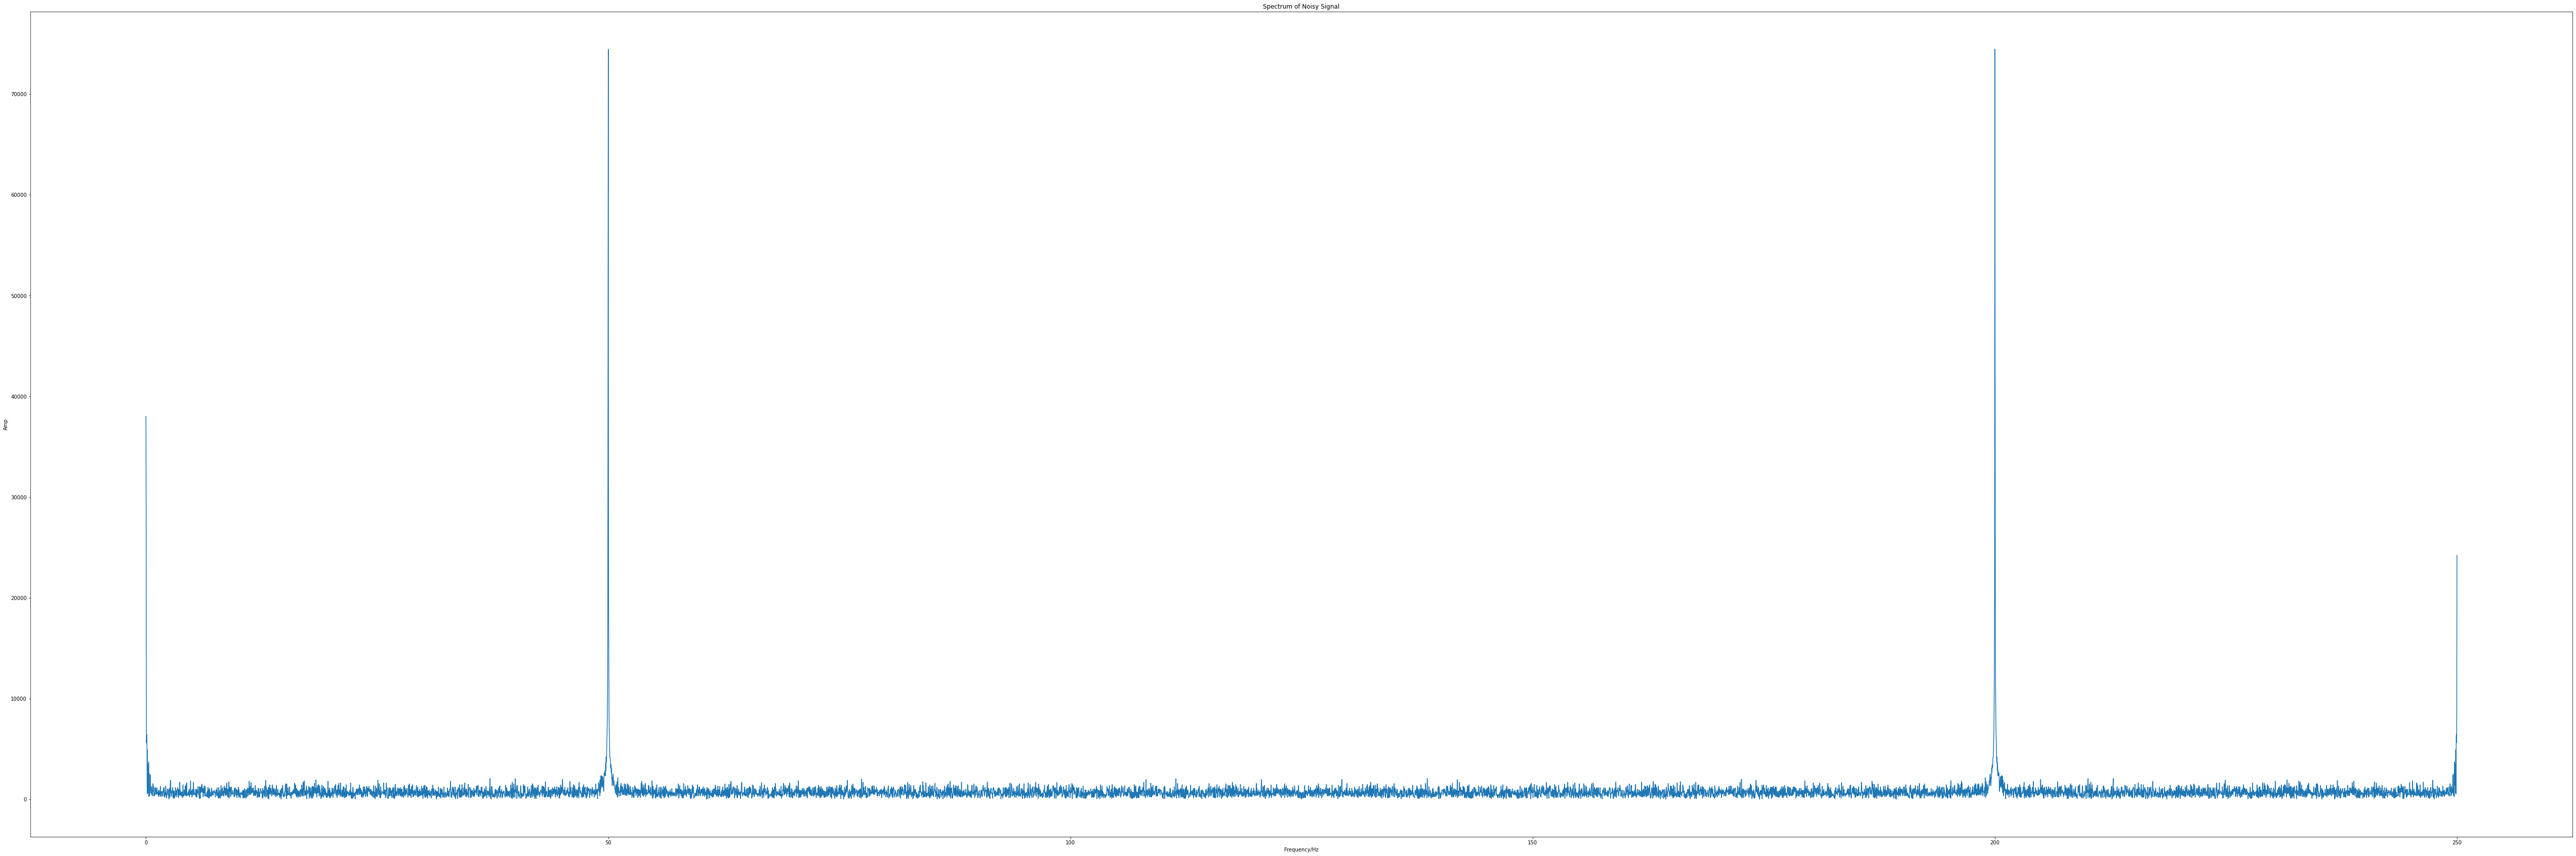

Frequcies of interest/Hz: [[  0.        ]
 [ 49.98419056]
 [ 50.01053963]
 [199.98946037]
 [200.01580944]] 



In [5]:
# Unpickle the file 'synthetic.pkl'
with open("synthetic.pkl", "rb") as fid:
    data = pickle.load(fid)

ts_noisy_acc = data['ACC'][:,0]    
noisy_acc_x = data['ACC'][:,1]
noisy_acc_y = data['ACC'][:,2]
noisy_acc_z = data['ACC'][:,3]


ts_noisy_mag = data['MAG'][:,0]  
noisy_mag_x = data['MAG'][:,1]
noisy_mag_y = data['MAG'][:,2]
noisy_mag_z = data['MAG'][:,3]

# Carry out an FFT analysis on the acc_x and plot the spectrum.
sample_freq=1/((ts_noisy_acc[1]-ts_noisy_acc[0])*1e-9)
frequency = np.arange(len(noisy_acc_x)) * (sample_freq / len(noisy_acc_x))
spectrum=np.abs(fft(noisy_acc_x))

fig, ax = plt.subplots(figsize=(90,30))


ax.plot(frequency, spectrum)
ax.set(xlabel = 'Frequency/Hz',
      ylabel = 'Amp',
      title = 'Spectrum of Noisy Signal')

plt.show()

spectrum_abs = np.abs(spectrum)
#peak locations
threshold= np.max(spectrum_abs)/2.0 #this threshold criteria will not capture the smaller peaks
# threshold = 20000
indices = np.argwhere( spectrum_abs > threshold)
print('Frequcies of interest/Hz: %s \n' % frequency[indices])

# Design a suitable filter to remove the noise.


# Run the filter over the dataset.

# ROUGH WORKINGS

In [6]:
# def normalize(a, b, c):
#     return (1 / (np.sqrt(((a**2) + (b**2) + (c**2)))))

# def getRotationMatrix(acc_x, acc_y, acc_z, mag_x, mag_y, mag_z):

#     a = np.array(([acc_x], [acc_y], [acc_z]))
#     m = np.array(([mag_x], [mag_y], [mag_z]))
#     a_cross_m = np.cross(a, m, axis=0)
#     a_cross_m_a = np.cross(a_cross_m, a, axis=0)

#     col0 = normalize(a_cross_m_a[0], a_cross_m_a[1], a_cross_m_a[2]) * a_cross_m_a
#     col1 = normalize(a_cross_m[0], a_cross_m[1], a_cross_m[2]) * a_cross_m
#     col2 = normalize(a[0], a[1], a[2]) * a

#     # R = np.hstack((
#     #     np.cross(a_cross_m, a, axis=0),
#     #     a_cross_m,
#     #     a
#     # ))

#     R = np.hstack((
#         col0,
#         col1,
#         col2
#     ))

#     return R

# def getOrientation(R):
#     pitch = - np.arcsin(R[0][2])
#     yaw = np.arctan((R[1][2] / R[2][2]))
#     roll = np.arctan((R[0][1] / R[0][0]))

#     return (pitch, yaw, roll)